In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install necessary libraries
!pip install --upgrade pip
!pip install --upgrade --force-reinstall numpy==2.0.2
!pip install nvidia-cufft-cu12
!pip install torch torchvision albumentations scikit-image pytorch-lightning seaborn captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 29.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 153.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 141.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 144.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 128.7 MB/s 

This code is partially based on https://github.com/tchanda90/Derma-XAI ()

In [ ]:
from albumentations.pytorch import ToTensorV2
from captum.attr import LayerAttribution, LayerGradCam
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from skimage import io
from sklearn import metrics
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import WeightedRandomSampler
from torchmetrics import Accuracy, AUROC, Recall, Specificity
from torchvision import models
from tqdm.auto import tqdm

import albumentations
import cv2
import json
import numpy as np
import os
import pandas as pd
import pytorch_lightning as pl
import random
import torch
import matplotlib.pyplot as plt
import pickle

# Setup

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
cv2.setNumThreads(1)
os.environ["OMP_NUM_THREADS"] = "1"

In [ ]:
BASE_DIR = "/content/drive/MyDrive/DATABase/"
IMG_DIR = os.path.join(BASE_DIR, "HAM10000_images")
METADATA_FILE = os.path.join(BASE_DIR, "metadata_ground_truth_with_splits.csv")

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [ ]:
NUM_EPOCHS = 25
LEARNING_RATE = 0.0001
BATCH_SIZE = 128
IMAGE_SIZE = 224

SAVE_ATTENTION_PLOTS = False
WEIGHTED_SAMPLING= True
ATTENTIOM_WEIGHT = 10
CHAR_WEIGHT = 1
DROPOUT = 0.4

DX_CLASS_LABEL = ['benign_malignant']

SEED = 42

seed_everything(SEED)

# Dataset

In [ ]:
class MelanomaDataset(Dataset):
    def __init__(self, root_dir, metadata, index=None, transform=None):
        self.root_dir = root_dir
        self.metadata = metadata
        if index is not None:
            self.metadata = self.metadata.loc[index]
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, index):
        image_name = self.metadata.iloc[index]['image_id']
        img_path = os.path.join(self.root_dir, image_name + '.jpg')

        image = io.imread(img_path)
        y_dx = torch.tensor(self.metadata.iloc[index][DX_CLASS_LABEL]).float()

        if self.transform:
            image = self.transform(image=image)['image']

        return image, (y_dx, image_name)

In [ ]:
def get_transforms(image_size, full=False):
    if full:
        transforms_train = albumentations.Compose([
            albumentations.Transpose(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.ColorJitter(p=0.5),
            albumentations.OneOf([
                albumentations.MotionBlur(blur_limit=5),
                albumentations.MedianBlur(blur_limit=5),
                albumentations.GaussianBlur(blur_limit=(3, 5)),
                albumentations.GaussNoise(var_limit=(5.0, 30.0)),
            ], p=0.7),
            albumentations.OneOf([
                albumentations.OpticalDistortion(distort_limit=1.0),
                albumentations.GridDistortion(num_steps=5, distort_limit=1.),
                albumentations.ElasticTransform(alpha=3),
            ], p=0.7),
            albumentations.CLAHE(clip_limit=4.0, p=0.7),
            albumentations.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
            albumentations.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
            albumentations.CoarseDropout(max_height=int(image_size * 0.375), max_width=int(image_size * 0.375), max_holes=1, p=0.3),
            albumentations.Resize(image_size, image_size),
            albumentations.Normalize(),
            ToTensorV2()
        ])
    else:
        transforms_train = albumentations.Compose([
            albumentations.Transpose(p=0.2),
            albumentations.VerticalFlip(p=0.2),
            albumentations.HorizontalFlip(p=0.2),
            albumentations.ColorJitter(p=0.5),
            albumentations.CLAHE(clip_limit=4.0, p=0.7),
            albumentations.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
            albumentations.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
            albumentations.CoarseDropout(max_height=int(image_size * 0.375), max_width=int(image_size * 0.375), max_holes=1, p=0.3),
            albumentations.Resize(image_size, image_size),
            albumentations.Normalize(),
            ToTensorV2()
        ])

    transforms_val = albumentations.Compose([
        albumentations.Resize(image_size, image_size),
        albumentations.Normalize(),
        ToTensorV2()
    ])
    return transforms_train, transforms_val

# Model

In [ ]:
class MelanomaClassifier(pl.LightningModule):
    def __init__(self, backbone_model, hidden_size=64, learning_rate=LEARNING_RATE, metadata_file=METADATA_FILE,
                 data_dir=IMG_DIR, batch_size=BATCH_SIZE, weighted_sampling=WEIGHTED_SAMPLING):

        super().__init__()
        self.backbone_model = backbone_model
        self.metadata_file = metadata_file
        self.data_dir = data_dir
        self.weighted_sampling = weighted_sampling
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.train_set, self.val_set, self.test_set = None, None, None

        self.loss = nn.BCELoss()

        self.labels = DX_CLASS_LABEL
        self.num_classes = len(DX_CLASS_LABEL) # == 1

        self.train_transform, self.test_transform = get_transforms(image_size=IMAGE_SIZE)

        if self.backbone_model == 'resnet18':
          resnet = models.resnet18(pretrained=True)
        elif self.backbone_model == 'resnet34':
          resnet = models.resnet34(pretrained=True)
        elif self.backbone_model == 'resnet50':
          resnet = models.resnet50(pretrained=True)
        elif self.backbone_model == 'resnet101':
          resnet = models.resnet101(pretrained=True)
        resnet.fc = nn.Sequential(
            nn.Dropout(p=DROPOUT),
            nn.Linear(in_features=resnet.fc.in_features, out_features=self.num_classes),
        )

        self.base_model = resnet
        self.sigm = nn.Sigmoid()

        self.accuracy = Accuracy(task='binary', threshold=0.5)
        self.auroc = AUROC(task='binary', average='macro')
        self.sensitivity = Recall(task='binary', threshold=0.5)
        self.specificity = Specificity(task='binary', threshold=0.5)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def forward(self, x):
        output = self.sigm(self.base_model(x))
        return output

    def on_train_start(self):
        self.log("hp/lr", self.learning_rate)
        self.log("hp/batch_size", float(self.batch_size))
        self.log("hp/dropout", DROPOUT)
        self.log("hp/weighted_sampling", float(self.weighted_sampling))

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_dx, image_name = y
        output = self(x)
        loss = self.loss(output, y_dx)
        self.log("train/loss", loss, on_epoch=True, on_step=False)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_dx, image_name = y
        with torch.no_grad():
            output = self(x)
        loss = self.loss(output, y_dx)
        self.log("val/loss", loss, on_epoch=True, on_step=False)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_dx, image_name = y
        with torch.no_grad():
            output = self(x)
        loss = self.loss(output, y_dx)
        self.accuracy(output.flatten(), y_dx.int().flatten())
        self.auroc(output.flatten(), y_dx.int().flatten())
        self.sensitivity(output.flatten(), y_dx.int().flatten())
        self.specificity(output.flatten(), y_dx.int().flatten())

    def on_test_epoch_end(self) -> None:
        self.log("test/bal_acc", self.accuracy.compute())
        self.log("test/auroc", self.auroc.compute())
        self.log("test/sensitivity", self.sensitivity.compute())
        self.log("test/specificity", self.specificity.compute())

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        x, y = batch
        y_dx, image_name = y
        with torch.no_grad():
            output = self(x)
        return output, y_dx, image_name

    def setup(self, stage=None):
        metadata = pd.read_csv(self.metadata_file)
        train_set = metadata[metadata['split'] == 'train']
        self.train_set = MelanomaDataset(root_dir=self.data_dir,
                                                            metadata=train_set,
                                                            transform=self.train_transform)
        val_set = metadata[metadata['split'] == 'val']
        self.val_set = MelanomaDataset(root_dir=self.data_dir,
                                                          metadata=val_set,
                                                          transform=self.test_transform)
        test_set = metadata[metadata['split'] == 'test']
        self.test_set = MelanomaDataset(root_dir=self.data_dir,
                                                           metadata=test_set,
                                                           transform=self.test_transform)

    def train_dataloader(self):
        if self.weighted_sampling:
            y = self.train_set.metadata[self.labels].values.flatten().astype(int)
            counts = np.bincount(y)
            labels_weights = 1. / counts
            weights = labels_weights[y]
            sampler = WeightedRandomSampler(weights, num_samples=len(weights))
            return DataLoader(self.train_set, batch_size=self.batch_size, shuffle=False, sampler=sampler, num_workers=16)
        else:
            return DataLoader(self.train_set, batch_size=self.batch_size, shuffle=True, num_workers=16)

    def val_dataloader(self):
        if False:# self.weighted_sampling:
            y = self.val_set.metadata[self.labels].values.flatten().astype(int)
            counts = np.bincount(y)
            labels_weights = 1. / counts
            weights = labels_weights[y]
            sampler = WeightedRandomSampler(weights, len(weights))
            return DataLoader(self.val_set, batch_size=self.batch_size, shuffle=False, sampler=sampler, num_workers=16)
        else:
            return DataLoader(self.val_set, batch_size=self.batch_size, shuffle=False, num_workers=16)

    def test_dataloader(self):
        return DataLoader(self.test_set, batch_size=self.batch_size, shuffle=False, num_workers=16)

    def predict_dataloader(self):
        return DataLoader(self.test_set, batch_size=self.batch_size, shuffle=False, num_workers=16)

# Testing

### Loading the models

In [ ]:
base_models = ['ResNet18', 'ResNet34', 'ResNet50', 'ResNet101']
trained_models = []
trainers = []

for base_model in base_models:
    checkpoints_path = os.path.join(BASE_DIR, f"binary_{base_model.lower()}/final_checkpoints.ckpt")
    trained_models.append(MelanomaClassifier.load_from_checkpoint(checkpoints_path,
                                                          map_location="cuda",
                                                          backbone_model=base_model.lower()))
    trained_models[-1].to("cuda")
    trained_models[-1].setup()
    trainers.append(Trainer(devices=1, accelerator="gpu", enable_progress_bar=True))
    print(f"Model with {base_model} backbone loaded successfully!")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 192MB/s]
INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Model with ResNet18 backbone loaded successfully!


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 199MB/s]
INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Model with ResNet34 backbone loaded successfully!


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 177MB/s]
INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Model with ResNet50 backbone loaded successfully!


Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 215MB/s]
INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Model with ResNet101 backbone loaded successfully!


### Prediction and evaluating

In [ ]:
def get_dx_predictions(trainer, model, split='test', threshold=0.5):
    """
    Stores predictions, scores, and true values in a DataFrame.
    """
    if split == 'test':
        predictions = trainer.predict(model, model.test_dataloader())
    else:
        predictions = trainer.predict(model, model.val_dataloader())

    dfs = []

    for preds in predictions:

        y_pred, y_true, image_name = preds
        df = pd.DataFrame(y_pred, columns=['score'])
        y_pred = torch.where(y_pred >= threshold, 1, 0)

        df['pred'] = y_pred
        df['true'] = y_true

        dfs.append(df)

    result = pd.concat(dfs, ignore_index=True).dropna()

    return result

In [ ]:
def find_optimal_cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = metrics.roc_curve(target, predicted)
    i = np.arange(len(tpr))
    roc = pd.DataFrame({'tf': pd.Series(tpr - (1 - fpr), index=i), 'threshold': pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf - 0).abs().argsort()[:1]]

    return roc_t['threshold'].item()

In [ ]:
def display_scores(result):
    true = 'true'
    score = 'score'
    pred = 'pred'
    print('=====')
    print('AUC:', metrics.roc_auc_score(result[true], result[score]))
    print('Balanced Acc:', metrics.balanced_accuracy_score(result[true], result[pred]))
    print('Sensitivity:', metrics.recall_score(result[true], result[pred]))
    print('Specificity:', metrics.recall_score(result[true], result[pred], pos_label=0))
    print('=====\n')

In [ ]:
def evaluate_model(trainer, model, model_name, val_results, thresholds, test_results):
    print('=================================')
    print(f'Model with {model_name} backbone')
    val_results[model_name] = get_dx_predictions(trainer, model, split='val', threshold=0.5)

    print('Val:')
    display_scores(val_results[model_name])
    thresholds[model_name] = find_optimal_cutoff(val_results[model_name]['true'], val_results[model_name]['score'])

    test_results[model_name] = get_dx_predictions(trainer, model, split='test', threshold=thresholds[model_name])
    print('Test:')
    display_scores(test_results[model_name])
    print('=================================\n\n')

In [ ]:
val_results, thresholds, test_results = dict(), dict(), dict()

In [ ]:
for i in range(len(base_models)):
    evaluate_model(trainers[i], trained_models[i], base_models[i], val_results, thresholds, test_results)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Model with ResNet18 backbone


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Val:
=====
AUC: 0.861127684333016
Balanced Acc: 0.7981169998942135
Sensitivity: 0.7159420289855073
Specificity: 0.8802919708029197
=====



Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Test:
=====
AUC: 0.8421184738955823
Balanced Acc: 0.7681838464970996
Sensitivity: 0.7592592592592593
Specificity: 0.7771084337349398
=====



Model with ResNet34 backbone


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Val:
=====
AUC: 0.8180429493282555
Balanced Acc: 0.751687295038612
Sensitivity: 0.6376811594202898
Specificity: 0.8656934306569343
=====



Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Test:
=====
AUC: 0.8609158857652833
Balanced Acc: 0.7932005800981705
Sensitivity: 0.7731481481481481
Specificity: 0.8132530120481928
=====



Model with ResNet50 backbone


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Val:
=====
AUC: 0.8053654924362637
Balanced Acc: 0.7534962445784408
Sensitivity: 0.7420289855072464
Specificity: 0.7649635036496351
=====



Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Test:
=====
AUC: 0.8542782240071396
Balanced Acc: 0.7850847835787595
Sensitivity: 0.7870370370370371
Specificity: 0.7831325301204819
=====



Model with ResNet101 backbone


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Val:
=====
AUC: 0.816303818893473
Balanced Acc: 0.7237067597588067
Sensitivity: 0.5043478260869565
Specificity: 0.9430656934306569
=====



Predicting: |          | 0/? [00:00<?, ?it/s]

Test:
=====
AUC: 0.8619756804997769
Balanced Acc: 0.7867302543507363
Sensitivity: 0.7361111111111112
Specificity: 0.8373493975903614
=====





In [ ]:
SAVE_DIR = os.path.join(BASE_DIR, "binary_classification_results")
os.makedirs(SAVE_DIR, exist_ok=True)

In [ ]:
with open(os.path.join(SAVE_DIR, "validation_results.pkl"), "wb") as f:
    pickle.dump(val_results, f)
with open(os.path.join(SAVE_DIR, "thresholds.pkl"), "wb") as f:
    pickle.dump(thresholds, f)
with open(os.path.join(SAVE_DIR, "test_results.pkl"), "wb") as f:
    pickle.dump(test_results, f)

# Using explainability

In [ ]:
SAVE_DIR = os.path.join(BASE_DIR, "binary_classification_results")
with open(os.path.join(SAVE_DIR, "validation_results.pkl"), "rb") as f:
    val_results = pickle.load(f)
with open(os.path.join(SAVE_DIR, "thresholds.pkl"), "rb") as f:
    thresholds = pickle.load(f)
with open(os.path.join(SAVE_DIR, "test_results.pkl"), "rb") as f:
    test_results = pickle.load(f)

In [ ]:
EXPLAINABILITY_SAVE_DIR = os.path.join(BASE_DIR, f"binary_classification_explainability_results")
os.makedirs(EXPLAINABILITY_SAVE_DIR, exist_ok=True)

## Calculating attributions and fidelity

In [ ]:
def forward(model, img):
    layer_gc = LayerGradCam(model.base_model, model.base_model.layer4[-1])
    with torch.enable_grad():
        output = model(img)
    if output.item() >= 0.5:
        attributions = layer_gc.attribute(img, 0, relu_attributions=True)
    else:
        attributions = layer_gc.attribute(img, 0, relu_attributions=False)
        attributions = torch.relu(-attributions)

    attributions = F.interpolate(attributions, size=(IMAGE_SIZE, IMAGE_SIZE), mode='bilinear')
    return output, attributions


In [ ]:
def calculate_attributions_and_fidelity(model, result, model_name, save_dir=EXPLAINABILITY_SAVE_DIR, mode='blacken'):
    save_dir = os.path.join(save_dir, model_name)
    os.makedirs(save_dir, exist_ok=True)
    output_scores_dict = {}
    attributions_dict = {}
    fidelity_dict = {}
    model.to("cuda")

    print(f"Calcilate fidelity for different percentiles for the model with {model_name} backbone")

    for percentile in range(5, 100, 5):
        print(f"Percentile: {percentile}")
        output_scores_dict.clear()
        for idx, row in tqdm(result.iterrows(), total=len(result), desc="Images processing"):
            # Read image (into CPU)
            img_id = row['image_id']
            if isinstance(img_id, (list, pd.Series, np.ndarray)):
                img_id = img_id[0]
            raw_img = io.imread(os.path.join(IMG_DIR, img_id + '.jpg'))
            # Apply transform
            transformed = model.test_transform(image=raw_img, mask=raw_img)
            img = transformed['image'].unsqueeze(0)  # (1, C, H, W)
            # Move the image to GPU
            img = img.to("cuda")

            # Do forward pass on GPU
            output, attributions = forward(model, img)
            # Move results to CPU
            output_cpu = output.detach().cpu()
            attributions_cpu = attributions.detach().cpu()

            # Resize attributions to the size (H, W)
            attr_map = attributions_cpu.squeeze().numpy()
            output_val = output_cpu.squeeze().item()
            attributions_dict[img_id] = (output_val, attr_map)

            # Fidelity for each image at percentile
            nonzero_vals = attr_map[attr_map > 0]
            perc_value = np.percentile(nonzero_vals, percentile) if nonzero_vals.size > 0 else 0
            # Binarize the attribution map: we get the mask (H, W)
            mask = (attr_map >= perc_value).astype(np.uint8)

            # Modify the image: convert the mask to a tensor and transfer it to the GPU
            mask_tensor = torch.from_numpy(mask).bool().to("cuda")
            new_img = img.clone()
            if mode == 'randomize':
                for c in range(new_img.shape[1]):
                    num_pixels = new_img[0, c][mask_tensor].numel()
                    random_vals = torch.tensor(np.random.choice(new_img.cpu().numpy().flatten(), size=num_pixels),
                                                 device="cuda").float()
                    new_img[0, c][mask_tensor] = random_vals
            elif mode == 'blacken':
                for c in range(new_img.shape[1]):
                    new_img[0, c][mask_tensor] = 0

            # Calculating a new prediction for the modified image
            new_output, new_attributions = forward(model, new_img)
            new_output_val = new_output.detach().cpu().squeeze().item()

            output_scores_dict[img_id] = [output_val, new_output_val]

        # Calculating fidelity for a given percentile
        output_diff = {key: abs(val[0] - val[1]) for key, val in output_scores_dict.items()}
        fidelity = np.array(list(output_diff.values()))
        fidelity_dict[percentile] = fidelity

        with open(os.path.join(save_dir, f"output_scores_{percentile}.json"), "w") as f:
            json.dump(output_scores_dict, f)

    np.savez(os.path.join(save_dir, "fidelity_dict.npz"), **{str(k): v for k, v in fidelity_dict.items()})
    with open(os.path.join(save_dir, "attributions_dict.pkl"), "wb") as f:
        pickle.dump(attributions_dict, f)

    return fidelity_dict, attributions_dict

### ResNet18

In [ ]:
model_index = base_models.index('ResNet18')
result = test_results[base_models[model_index]]
result = pd.concat([trained_models[model_index].test_set.metadata[["image_id", "lesion_id"]].reset_index(drop=True),
                    result.reset_index(drop=True)], axis=1)
result.rename({'pred': 'prediction'}, axis=1, inplace=True)
result.head()

,image_id,lesion_id,score,prediction,true
0,ISIC_0031023,HAM_0005678,0.999976,1,1.0
1,ISIC_0031177,HAM_0005191,0.936684,1,1.0
2,ISIC_0030417,HAM_0004476,0.999877,1,1.0
3,ISIC_0032396,HAM_0000876,0.999824,1,1.0
4,ISIC_0025450,HAM_0003832,0.004063,0,1.0


In [ ]:
fidelity_dict, attributions_dict = calculate_attributions_and_fidelity(trained_models[model_index], result, base_models[model_index])

Calcilate fidelity for different percentiles for the model with ResNet18 backbone
Percentile: 5


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 10


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 15


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 20


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 25


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 30


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 35


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 40


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 45


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 50


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 55


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 60


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 65


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 70


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 75


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 80


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 85


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 90


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 95


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

### ResNet34

In [ ]:
model_index = base_models.index('ResNet34')
result = test_results[base_models[model_index]]
result = pd.concat([trained_models[model_index].test_set.metadata[["image_id", "lesion_id"]].reset_index(drop=True),
                    result.reset_index(drop=True)], axis=1)
result.rename({'pred': 'prediction'}, axis=1, inplace=True)
result.head()

,image_id,lesion_id,score,prediction,true
0,ISIC_0031023,HAM_0005678,0.999414,1,1.0
1,ISIC_0031177,HAM_0005191,0.990515,1,1.0
2,ISIC_0030417,HAM_0004476,0.997283,1,1.0
3,ISIC_0032396,HAM_0000876,0.996967,1,1.0
4,ISIC_0025450,HAM_0003832,0.855387,1,1.0


In [ ]:
fidelity_dict_34, attributions_dict_34 = calculate_attributions_and_fidelity(trained_models[model_index], result, base_models[model_index])

Calcilate fidelity for different percentiles for the model with ResNet34 backbone
Percentile: 5


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 10


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 15


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 20


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 25


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 30


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 35


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 40


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 45


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 50


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 55


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 60


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 65


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 70


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 75


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 80


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 85


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 90


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 95


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

### ResNet50

In [ ]:
model_index = base_models.index('ResNet50')
result = test_results[base_models[model_index]]
result = pd.concat([trained_models[model_index].test_set.metadata[["image_id", "lesion_id"]].reset_index(drop=True),
                    result.reset_index(drop=True)], axis=1)
result.rename({'pred': 'prediction'}, axis=1, inplace=True)
result.head()

,image_id,lesion_id,score,prediction,true
0,ISIC_0031023,HAM_0005678,0.999995,1,1.0
1,ISIC_0031177,HAM_0005191,0.991220,1,1.0
2,ISIC_0030417,HAM_0004476,0.999867,1,1.0
3,ISIC_0032396,HAM_0000876,1.000000,1,1.0
4,ISIC_0025450,HAM_0003832,0.036743,0,1.0


In [ ]:
fidelity_dict_50, attributions_dict_50 = calculate_attributions_and_fidelity(trained_models[model_index], result, base_models[model_index])

Calcilate fidelity for different percentiles for the model with ResNet50 backbone
Percentile: 5


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 10


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 15


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 20


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 25


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 30


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 35


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 40


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 45


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 50


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 55


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 60


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 65


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 70


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 75


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 80


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 85


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 90


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 95


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

### ResNet101

In [ ]:
model_index = base_models.index('ResNet101')
result = test_results[base_models[model_index]]
result = pd.concat([trained_models[model_index].test_set.metadata[["image_id", "lesion_id"]].reset_index(drop=True),
                    result.reset_index(drop=True)], axis=1)
result.rename({'pred': 'prediction'}, axis=1, inplace=True)
result.head()

,image_id,lesion_id,score,prediction,true
0,ISIC_0031023,HAM_0005678,0.996284,1,1.0
1,ISIC_0031177,HAM_0005191,0.816785,1,1.0
2,ISIC_0030417,HAM_0004476,0.987938,1,1.0
3,ISIC_0032396,HAM_0000876,0.999054,1,1.0
4,ISIC_0025450,HAM_0003832,0.000050,0,1.0


In [ ]:
fidelity_dict_101, attributions_dict_101 = calculate_attributions_and_fidelity(trained_models[model_index], result, base_models[model_index])

Calcilate fidelity for different percentiles for the model with ResNet101 backbone
Percentile: 5


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 10


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 15


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 20


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 25


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 30


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 35


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 40


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 45


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 50


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 55


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 60


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 65


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 70


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 75


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 80


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 85


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 90


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

Percentile: 95


Images processing:   0%|          | 0/382 [00:00<?, ?it/s]

## Analysing fidelity (ResNet101)

Change model_name to test other backbones.

In [ ]:
model_name = "ResNet101"

In [ ]:
save_dir = save_dir = os.path.join(EXPLAINABILITY_SAVE_DIR, model_name)

loaded = np.load(os.path.join(save_dir, "fidelity_dict.npz"))

fidelity_dict = {key: loaded[key] for key in loaded.files}

In [ ]:
dfs = []
for percentile in fidelity_dict.keys():
    df = pd.DataFrame(fidelity_dict[percentile], columns=['Fidelity'])
    df['Threshold'] = percentile
    dfs.append(df)
fidelity_df = pd.concat(dfs)

In [ ]:
fidelity_df.to_csv(os.path.join(SAVE_DIR, f"{model_name}_fidelity.csv"), index=False)

In [ ]:
percentiles = sorted([int(key) for key in fidelity_dict.keys()])

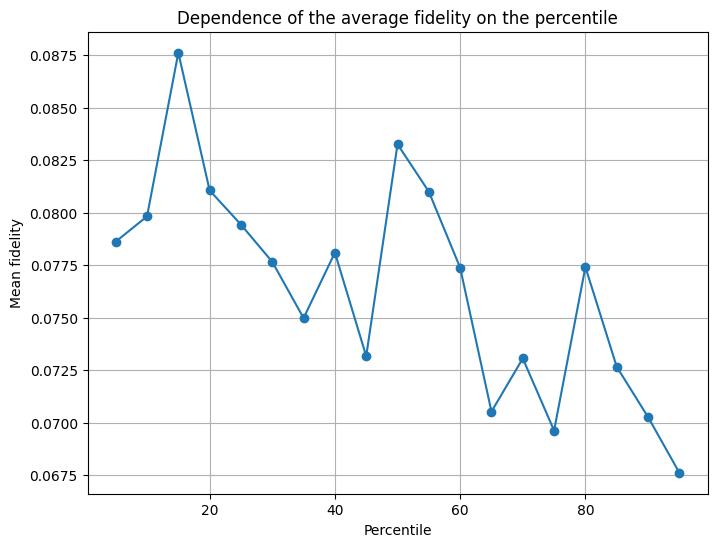

In [ ]:
mean_fidelity = [np.mean(fidelity_dict[str(p)]) for p in percentiles]

plt.figure(figsize=(8, 6))
plt.plot(percentiles, mean_fidelity, marker='o', linestyle='-')
plt.xlabel("Percentile")
plt.ylabel("Mean fidelity")
plt.title("Dependence of the average fidelity on the percentile")
plt.grid(True)
plt.show()

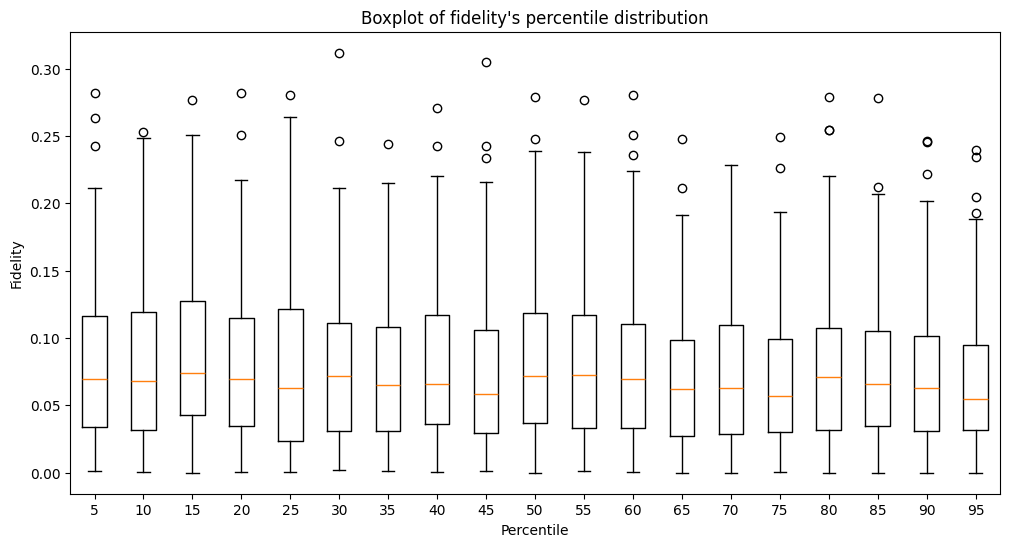

In [ ]:
data_to_plot = [fidelity_dict[str(p)] for p in percentiles]

plt.figure(figsize=(12, 6))
plt.boxplot(data_to_plot, labels=percentiles)
plt.xlabel("Percentile")
plt.ylabel("Fidelity")
plt.title("Boxplot of fidelity's percentile distribution")
plt.show()

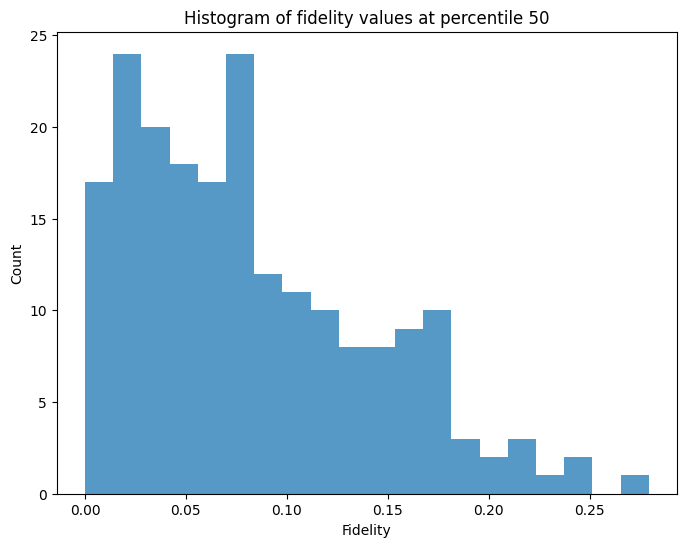

In [ ]:
selected_percentile = 50
if str(selected_percentile) in fidelity_dict:
    plt.figure(figsize=(8, 6))
    plt.hist(fidelity_dict[str(selected_percentile)], bins=20, alpha=0.75)
    plt.xlabel("Fidelity")
    plt.ylabel("Count")
    plt.title(f"Histogram of fidelity values at percentile {selected_percentile}")
    plt.show()
else:
    print(f"Percentile {selected_percentile} not found in fidelity_dict")

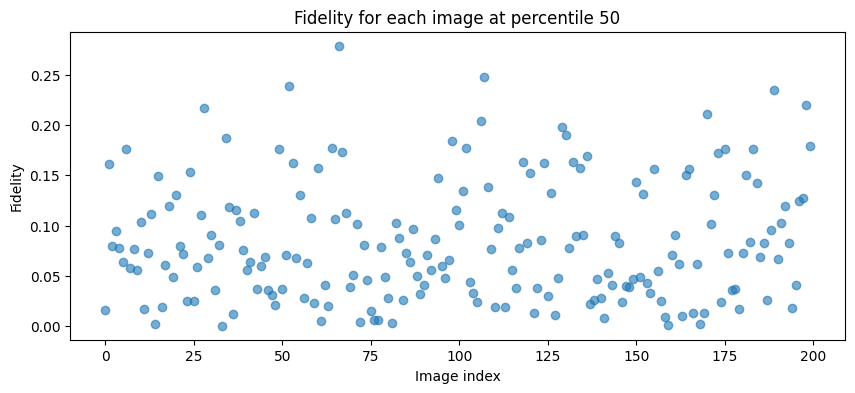

In [ ]:
if str(selected_percentile) in fidelity_dict:
    fidelity_values = fidelity_dict[str(selected_percentile)]
    plt.figure(figsize=(10, 4))
    plt.scatter(range(len(fidelity_values)), fidelity_values, alpha=0.6)
    plt.xlabel("Image index")
    plt.ylabel("Fidelity")
    plt.title(f"Fidelity for each image at percentile {selected_percentile}")
    plt.show()
else:
    print(f"Percentile {selected_percentile} not found in fidelity_dict")

## Visualizing attributions (ResNet101)

In [ ]:
from skimage import io, measure

In [ ]:
def visualize_attribution_contour_with_predictions(image_id, attributions_dict, predictions_df, threshold_percentile=80):
    """
    Visualizes the attribution map for a given image by drawing contours on the original image.
    The plot title includes the true label and prediction score from the predictions DataFrame.

    Parameters:
    - image_id: The unique identifier for the image.
    - attributions_dict: Dictionary mapping image IDs to a tuple (model output, attribution map).
    - predictions_df: DataFrame containing columns 'image_id', 'true', and 'score'.
    - threshold_percentile: The percentile to use for binarizing the attribution map (default: 80).
    """
    # Retrieve model output and attribution map for the given image_id.
    output, attr_map = attributions_dict[image_id]

    # Get the corresponding prediction row (true label and prediction score) from predictions_df.
    row = predictions_df[predictions_df['image_id'] == image_id].iloc[0]
    true_label = row['true']
    score = row['score']

    # Load the original image.
    original_img = io.imread(os.path.join(IMG_DIR, f"{image_id}.jpg"))

    # Normalize the attribution map.
    attr_norm = (attr_map - np.min(attr_map)) / (np.max(attr_map) - np.min(attr_map) + 1e-8)

    # Compute threshold based on the specified percentile of non-zero values.
    nonzero_vals = attr_norm[attr_norm > 0]
    thresh = np.percentile(nonzero_vals, threshold_percentile) if nonzero_vals.size > 0 else 0

    # Binarize the attribution map.
    binary_map = attr_norm >= thresh

    # Find contours in the binary map.
    contours = measure.find_contours(binary_map, level=0.5)

    # Plot the original image and overlay the contours.
    plt.figure(figsize=(8, 6))
    plt.imshow(original_img)
    for contour in contours:
        plt.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')
    plt.title(f"Image: {image_id}\nTrue Label: {true_label}, Score: {score:.3f}", fontsize=15)
    plt.axis('off')
    plt.show()

Change model_name to test other backbones.

In [ ]:
model_name = 'ResNet101'

In [ ]:
model_index = base_models.index(model_name)
result = test_results[base_models[model_index]]
result = pd.concat([trained_models[model_index].test_set.metadata[["image_id", "lesion_id"]].reset_index(drop=True),
                    result.reset_index(drop=True)], axis=1)
result.rename({'pred': 'prediction'}, axis=1, inplace=True)
result.head()

,image_id,lesion_id,score,prediction,true
0,ISIC_0031023,HAM_0005678,0.996284,1,1.0
1,ISIC_0031177,HAM_0005191,0.816785,1,1.0
2,ISIC_0030417,HAM_0004476,0.987938,1,1.0
3,ISIC_0032396,HAM_0000876,0.999054,1,1.0
4,ISIC_0025450,HAM_0003832,0.000050,0,1.0


In [ ]:
EXPLAINABILITY_SAVE_DIR = os.path.join(BASE_DIR, f"binary_classification_explainability_results")
model_name = 'ResNet101'
save_dir = os.path.join(EXPLAINABILITY_SAVE_DIR, model_name)

In [ ]:
with open(os.path.join(save_dir, "attributions_dict.pkl"), "rb") as f:
    attributions_dict = pickle.load(f)

### Visualization of choosen true positive predictions

In [ ]:
image_ids = ["ISIC_0027721", "ISIC_0030211", "ISIC_0030119", "ISIC_0026458"]

In [ ]:
for image_id in image_ids:
  visualize_attribution_contour_with_predictions(image_id, attributions_dict, result)

Output hidden; open in https://colab.research.google.com to view.

### Visualization of random predictions

In [ ]:
tp = result[(result['true'] == 1) & (result['prediction'] == 1)]
tn = result[(result['true'] == 0) & (result['prediction'] == 0)]
fp = result[(result['true'] == 0) & (result['prediction'] == 1)]
fn = result[(result['true'] == 1) & (result['prediction'] == 0)]

tp_sample = tp.sample(n=2, random_state=42)
tn_sample = tn.sample(n=2, random_state=42)
fp_sample = fp.sample(n=2, random_state=42)
fn_sample = fn.sample(n=2, random_state=42)

subset = pd.concat([tp_sample, tn_sample, fp_sample, fn_sample], ignore_index=True)

for idx, row in subset.iterrows():
    img_id = row['image_id']

    if row['true'] == 1 and row['prediction'] == 1:
        cls = "TP"
    elif row['true'] == 0 and row['prediction'] == 0:
        cls = "TN"
    elif row['true'] == 0 and row['prediction'] == 1:
        cls = "FP"
    elif row['true'] == 1 and row['prediction'] == 0:
        cls = "FN"

    print(f"Visualizing {cls} for image_id: {img_id}")
    visualize_attribution_contour_with_predictions(img_id, attributions_dict, result)

Output hidden; open in https://colab.research.google.com to view.